# Order 1 methods for unconstrained optimization

The goal of this lab is to get a feel for gradient-based optimisation methods. Throughout the lab we will be working with the [Rosenbrock function](https://www.wikiwand.com/en/Rosenbrock_function) which is defined as:

$$f(x,y)=(x_0 - a)^{2}+b(x_0^2 - x_1)^{2}$$

We will be setting the parameters such that $a=1$ and $b=10$, which is:

$$f(x,y)=(x_0 - 1)^{2}+10(x_0^2 - x_1)^{2}$$

The goal is thus to find a pair of values $(x_0, x_1)$ such that $f(x_0, x_1)$ is minimal. The Rosenbrock function is two-dimensional so for each method we should be able to plot the progress of each method, along with [contour lines](https://www.wikiwand.com/en/Contour_line).

Let's start by writing down the Rosenbrock function.

In [1]:
def f(X, a=1, b=10):
    (x0, x1) = X  # This is called a "destructuring assignment"
    return (x0 - a) ** 2 + b * (x0 ** 2 - x1) ** 2
    
f([1, 2])

10

Let's now write down the gradient of the Rosenbrock function.

$$\begin{cases}
\frac{\partial f}{\partial x_0} = 2 (x_0 - a) + 4bx_0 (x_0^2 - x_1) \\
\frac{\partial f}{\partial x_1} = -2b (x_0^2 - x_1)
\end{cases}$$


In [2]:
import numpy as np

def g(X, a=1, b=10):
    (x0, x1) = X
    dx0 = 2*(x0-a) + 4*b*x0 * (x0**2-x1)
    dx1 = -2*b * (x0**2 - x1)
    return np.array((dx0, dx1))

g([3, 3])

array([ 724, -120])

We can draw a contour plot of the function.

In [3]:
import matplotlib.pyplot as plt


def plot_contour(a, b, c, d, f, ax):
    delta = 0.05
    x0, x1 = np.meshgrid(np.arange(a, b, delta), np.arange(c, d, delta)) 
    ax.contour(x0, x1, f((x0, x1)), 500)
    

# This doesn't work with Jupyter Lab (as of October 2018), please use Jupyter Notebook
%matplotlib notebook  

fig, ax = plt.subplots()

plot_contour(-2, 2, -2, 2, f, ax)

<IPython.core.display.Javascript object>

## Vanilla gradient descent

Let's get down to business.

In [4]:
class VanillaGD():
    
    def __init__(self, X0, step, n_iterations):
        self.X0 = np.array(X0)
        self.step = step
        self.n_iterations = n_iterations
        
    def optimize(self, g):
        
        X = self.X0.copy()
        trace = np.zeros(shape=(self.n_iterations, len(X)))

        for i in range(self.n_iterations):

            # Move X along it's gradient
            d = -g(X)
            X =  X + self.step * d

            # Store the new position
            trace[i] = X

        return trace
        

opt = VanillaGD(X0=[-1.0, 1.0], step=0.01, n_iterations=100)
trace = opt.optimize(g)

We can plot the progress of the gradient descent.

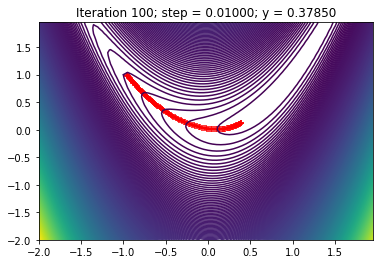

In [5]:
import time


def plot_trace(trace, steps, f, ax):
    for i, (x0, x1) in enumerate(trace):
        ax.scatter(x0, x1, color='red', marker='+')
        ax.set_title('Iteration {}; step = {:.5f}; y = {:.5f}'.format(i+1, steps[i], f((x0, x1))))
        fig.canvas.draw()

fig, ax = plt.subplots()
plt.ion()

plot_contour(-2, 2, -2, 2, f, ax)
plot_trace(trace, [0.01] * len(trace), f, ax)

## The Armijo-Goldstein rule

The algorithm is described [here](https://www.wikiwand.com/en/Backtracking_line_search).

In [6]:
class ArmijoLineSearch():
    
    def __init__(self, c, max_step):
        self.c = c
        self.max_step = max_step
        
    def find_step(self, f, g, X):
        
        # We start by precomputing some values
        step = self.max_step
        y = f(X)
        d = -g(X)
        m = np.dot(-d, d)

        # Then we divide the step size by 2 until the Armijo-Goldstein condition is met
        while f(X + step * d) > y + self.c * step * m:
            step /= 2

        return step

In [16]:
class LineSearchGD():
    
    def __init__(self, X0, ls, n_iterations):
        self.ls = ls
        self.X0 = np.array(X0)
        self.n_iterations = n_iterations
        
    def optimize(self, f, g):
        
        X = self.X0.copy()
        trace = np.zeros(shape=(self.n_iterations, len(X)))
        steps = np.zeros(shape=self.n_iterations)

        for i in range(self.n_iterations):

            # Compute the gradient
            gradient = g(X)

            # Find the optimal step size
            step = self.ls.find_step(f, g, X)

            # Move X along it's gradient
            X -= step * gradient

            # Store the new position and the new step size 
            trace[i] = X
            steps[i] = step

        return trace, steps

ls = ArmijoLineSearch(c=0.0001, max_step=0.1)
opt = LineSearchGD(ls=ls, X0=[-1.0, 1.0], n_iterations=100)
trace, steps = opt.optimize(f=f, g=g)

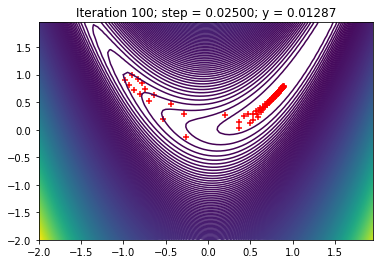

In [8]:
fig, ax = plt.subplots()
plt.ion()

plot_contour(-2, 2, -2, 2, f, ax)
plot_trace(trace, steps, f, ax)

## The Wolfe conditions

The two conditions are:

- a
- b

The first condition is the Armijo-Goldstein rule while the second condition is known as the **curvature condition**.

In [9]:
class WolfeLineSearch():
    
    def __init__(self, c1, c2, min_step, max_step, max_iterations=50):
        self.c1 = c1
        self.c2 = c2
        self.min_step = min_step
        self.max_step = max_step
        self.max_iterations = max_iterations
        
    def find_step(self, f, g, X):
        
        # We start by precomputing some values
        min_step = self.min_step
        max_step = self.max_step
        step = (min_step + max_step) / 2
        y = f(X)
        d = -g(X)
        m = np.sum(-d * d)

        # Define the first condition
        def check_condition_1(step):
            return f(X + step * d) > y + self.c1 * step * m

        # Define the second condition
        def check_condition_2(step):
            return np.sum(g(X + step * d) * d) < self.c2 * m

        # Then we divide the step size by 2 as long as one of the conditions is met
        condition_1 = check_condition_1(step)
        condition_2 = check_condition_2(step)
        n_iterations = 0

        while (condition_1 or condition_2) and n_iterations < self.max_iterations:

            if condition_1:
                max_step = step
            else:
                min_step = step

            step = (min_step + max_step) / 2

            condition_1 = check_condition_1(step)
            condition_2 = check_condition_2(step)
            n_iterations += 1

        return step

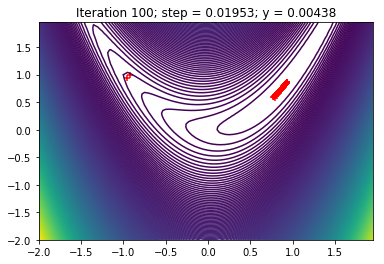

In [10]:
ls = WolfeLineSearch(c1=0.0001, c2=0.7, min_step=0, max_step=10)
opt = LineSearchGD(X0=[-1.0, 1.0], ls=ls, n_iterations=100)
trace, steps = opt.optimize(f=f, g=g)

fig, ax = plt.subplots()
plt.ion()

plot_contour(-2, 2, -2, 2, f, ax)
plot_trace(trace, steps, f, ax)

## Computing the optimal step size

In [11]:
class OptimalLineSearch():
    
    def find_step(self, f, g, X):
        
        (x, y) = X
        grad = g(X)
        (g, h) = grad

        b = 10
        g2 = g**2
        aux = h - 2 * x *g
        aux2 = x**2 - y
        
        polynomial = [
            4 * b * g ** 4,
            (6*b*g2) * aux,
            2 * (g2 + 2 * b * g2 * aux2 + b * aux ** 2),
            -g * (x-1) + b * aux2 * aux
        ]
        
        roots = np.roots(polynomial)
        step = min([root for root np.real(roots) if root > 0])

        return step

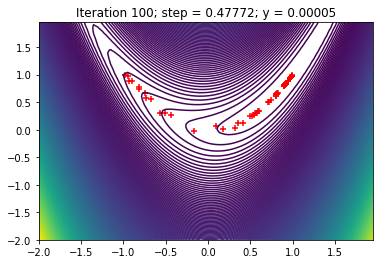

In [12]:
ls = OptimalLineSearch()
opt = LineSearchGD(X0=[-1.0, 1.0], ls=ls, n_iterations=100)
trace, steps = opt.optimize(f=f, g=g)

fig, ax = plt.subplots()
plt.ion()

plot_contour(-2, 2, -2, 2, f, ax)
plot_trace(trace, steps, f, ax)

## Global comparison

In [13]:
step = 0.04
X0 = [-1.0, 1.0]
n_iterations = 100

traces = {}
steps = {}

opt = VanillaGD(X0=X0, step=step, n_iterations=n_iterations)
t = opt.optimize(g)
traces['Vanilla'] = t
steps['Vanilla'] = [step] * len(t)

ls = ArmijoLineSearch(c=0.0001, max_step=step)
opt = LineSearchGD(X0=X0, ls=ls, n_iterations=n_iterations)
t, s = opt.optimize(f=f, g=g)
traces['Armijo rule'] = t
steps['Armijo rule'] = s

ls = WolfeLineSearch(c1=0.0001, c2=0.7, min_step=0, max_step=step)
opt = LineSearchGD(X0=X0, ls=ls, n_iterations=n_iterations)
t, s = opt.optimize(f=f, g=g)
traces['Wolfe conditions'] = t
steps['Wolfe conditions'] = s

ls = OptimalLineSearch()
opt = LineSearchGD(X0=X0, ls=ls, n_iterations=n_iterations)
t, s = opt.optimize(f=f, g=g)
traces['Optimal'] = t
steps['Optimal'] = s

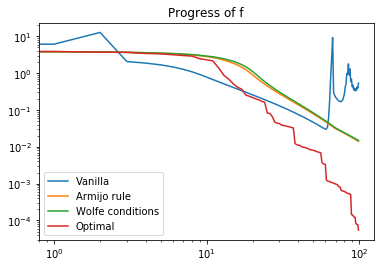

In [14]:
fig, ax = plt.subplots()

for method, trace in traces.items():
    ys = [f(x) for x in trace]
    ax.loglog(ys, label=method);

ax.set_title('Progress of f')
ax.legend();

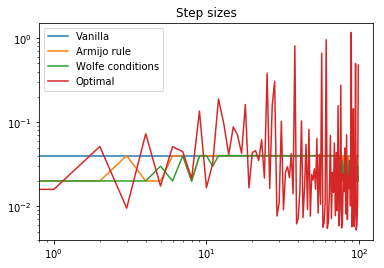

In [15]:
fig, ax = plt.subplots()

for method, step in steps.items():
    ax.loglog(step, label=method);

ax.set_title('Step sizes')
ax.legend();